## 1D Convolutions for Time Series Analysis


In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import make_grid
from ipywidgets import IntProgress, FloatProgress
%matplotlib qt

## Exploring the Data
Lets upload the time series data which I have scraped from www.bitcoincharts.com


In [2]:
df = pd.read_csv('btc_clean.csv')
df.head()


,Unnamed: 0,index,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,0,0,2020-03-23 00:00:00,5816.57,5824.12,5777.31,5797.57,42.10,243958.82,5794.81
1,1,1,2020-03-23 00:01:00,5797.57,5797.57,5783.38,5792.68,4.20,24324.38,5789.15
2,2,2,2020-03-23 00:02:00,5788.00,5792.71,5693.16,5693.16,97.88,560931.90,5730.97
3,3,3,2020-03-23 00:03:00,5693.16,5860.00,5686.34,5843.15,143.37,830444.75,5792.38
4,4,4,2020-03-23 00:04:00,5856.42,5859.98,5768.77,5809.70,72.85,423209.54,5809.01


## Creating labels 

We have to differentiate between two cases:
1. The current price is higher than the last X prices and also higher than the next X prices (time to sell)
2. The current price is lower than the last X prices and also lower than the next X prices (time to buy)


Ideally we want a oscilator that tells us how close we are to either of the two cases e.g. "0.98 --> sell and 0.12 --> buy" or something similar.

To achieve this we employ two centered moving window calculations.

In [3]:
wnd = 500
df['low'] = df['Close'].rolling(window=wnd,center=True).min()
df['high'] = df['Close'].rolling(window=wnd,center=True).max()

df['span'] = df['high'] - df['low'] 
df['val'] = df['Close'] - df['low'] # if Close is equal to the low of the last 50 and future 50 prices, val will evaluate to 0 --> time to buy
df['ratio'] = df['val'] / df['span'] 
df['ratio'] = df['ratio'].rolling(window=10,center=True).mean()

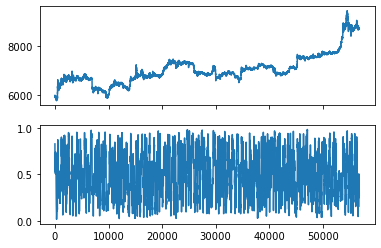

In [60]:
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(df['Close'])
ax2.plot(df['ratio'])

Lets limit our DataFrame to only the essential columns and crop out the beginning and the end which contains NaN values due to the rolling windows and save to numpy arrays


In [5]:
cutoff = int((wnd/2)+5)
df = df[['Open','High','Low','Close','Volume (Currency)','ratio']][cutoff:len(df)-cutoff].reset_index(drop=True) 
inputs = df[['Open','High','Low','Close','Volume (Currency)']].values
targets = df['ratio'].values


In [6]:
len(df)

56804

## Creating Datasets & Data Loaders

We can now create a dataset by using the TensorDataset Function. As we are not working with images but with "raw" data point we can create our input sample with a loop. (maybe not the most pretty way of doing it but we only have to do it once)

In the same step we also normalize the inputs. As we are working with sequential Data we have to normalize per sample and not over the entire data set.

The lookback variable defines how many past data points we want to feed into our model to predict the oscilator.

In [7]:
lookback = 500 
inputs_list = []
for x in range(lookback,len(inputs)):
    inp = inputs[x-lookback:x]
    inp = np.moveaxis(inp, -1, 0) # Channels must come first
    inputs_list.append(inp)

In [8]:

targets_list = []
for x in range(lookback,len(targets)):
    target = targets[x]
    targets_list.append(target)

## Normalization

In [9]:
inputs_normalized = []
for arr in inputs_list:
    mean = np.mean(arr, axis=1)
    var = np.std(arr,axis=1)
    means_vec = mean.reshape((5, 1))
    var_vec = var.reshape((5, 1))
    arr = arr - means_vec
    arr = arr / var_vec
    inputs_normalized.append(arr)

# inputs_normalized[0]
  

In [10]:
len(targets_list)

56304

## Creating the Dataset

The dataset has 56304 samples and we will hold out 6304 samples for testing.

In [11]:
batch_size= 10
tensor_x = torch.Tensor(inputs_normalized[:50000]) # transform to torch tensor 
tensor_y = torch.Tensor(targets_list[:50000]).view(-1,1)
my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset


In [12]:
val_pct = 0.1
val_size = int(val_pct * len(my_dataset))
train_size = len(my_dataset) - val_size

train_ds, val_ds = random_split(my_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [13]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

As you can see below we have 128 samples with 5 "color chanels" which are the different price series(open, high, low, close, volume)

In [14]:
for batch in train_loader:
  print(batch[0].size())
  print(batch[1].size())
  break

torch.Size([10, 5, 500])
torch.Size([10, 1])


## Creating the Model

The following setup is taken from a Pytorch Tutorial/ Course on Image classification.
The Architecture is very simple just to get started.



In [15]:
class TimeSeriesBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.l1_loss(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.l1_loss(out, targets)               # Calculate loss
        return {'val_loss': loss.detach() }

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

class BTCModel(TimeSeriesBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv1d(5, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(10, 50, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(50, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),

            nn.Flatten(), 
            nn.Linear(10, 1)

        )
        
    def forward(self, xb):
        return self.network(xb)



In [16]:
model = BTCModel()
model


BTCModel(
  (network): Sequential(
    (0): Conv1d(5, 10, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(10, 50, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(50, 10, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): AdaptiveAvgPool1d(output_size=1)
    (9): Flatten()
    (10): Linear(in_features=10, out_features=1, bias=True)
  )
)

### Some more helper functions

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cpu')

In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

BTCModel(
  (network): Sequential(
    (0): Conv1d(5, 10, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(10, 50, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(50, 10, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): AdaptiveAvgPool1d(output_size=1)
    (9): Flatten()
    (10): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [20]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([10, 5, 500])
out.shape: torch.Size([10, 1])
out[0]: tensor([-0.2850], grad_fn=<SelectBackward>)


## Training the model

In [21]:
from tqdm.notebook import tqdm

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
model = to_device(model, device)

In [24]:
evaluate(model, val_dl)

{'val_loss': 0.7784448266029358}

In [25]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 1e-6

In [26]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6988, val_loss: 0.6057
Epoch [1], train_loss: 0.5018, val_loss: 0.3881
Epoch [2], train_loss: 0.2943, val_loss: 0.2218
Epoch [3], train_loss: 0.2002, val_loss: 0.1935
Epoch [4], train_loss: 0.1915, val_loss: 0.1930
Epoch [5], train_loss: 0.1912, val_loss: 0.1928
Epoch [6], train_loss: 0.1910, val_loss: 0.1926
Epoch [7], train_loss: 0.1908, val_loss: 0.1924
Epoch [8], train_loss: 0.1906, val_loss: 0.1922
Epoch [9], train_loss: 0.1904, val_loss: 0.1920


## Making predictions 

create the test set

In [27]:
batch_size= 10
test_x = torch.Tensor(inputs_normalized[50000:]) # transform to torch tensor 
test_y = torch.Tensor(targets_list[50000:]).view(-1,1)
test_set = TensorDataset(test_x,test_y) # create your datset

In [28]:
len(test_set)

6304

In [29]:
test_dl = DeviceDataLoader(DataLoader(test_set, batch_size, num_workers=2, pin_memory=True), device)

In [30]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return batch_probs

In [31]:
test_preds = predict_dl(test_dl, model)
len(test_preds)

6304

In [32]:
test_preds.size()

torch.Size([6304, 1])

### Maping the predinctions to the orignial dataframe

First, we isolate only the test portion of our original Dataframe. 

The entries from 50000 to the end contain our test results but we have to exclude the first 500 of those because of our 500 time step lookback window. This isolated test portion of the Dataframe must be exactly as long as the predictions from our model. 
len(test_df) must be equal len(test_preds)

In [61]:
test_df = df[50500:]
len(test_df),len(test_preds)

(6304, 6304)

Looks good!

Next, we create a new columne 'preds' that contains the predicted buy/sell signal.

In [50]:
test_df['preds']= test_preds[:,0]

Lets plot what we got. Closer to 0 means 'buy!' and closer to 1 means 'sell!'

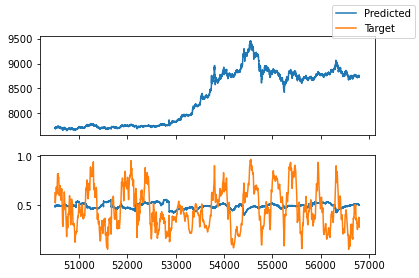

In [51]:
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(test_df['Close'])
ax2.plot(test_df['preds'], label='Predicted')
ax2.plot(test_df['ratio'], label='Target')
fig.legend()

We can see that see that the predicted values oscilate on a much more narrow scale which makes it hard to compare the targets.
Do our predictions follow a normal distribution?


(array([  14.,   15.,   11.,   52.,   95.,  135.,  127.,  279.,  445.,
         669.,  565., 1006.,  787.,  498.,  513.,  421.,  372.,  194.,
          63.,   43.]),
 array([0.39612132, 0.40419397, 0.4122666 , 0.42033926, 0.4284119 ,
        0.43648458, 0.44455722, 0.45262986, 0.4607025 , 0.46877515,
        0.4768478 , 0.48492044, 0.4929931 , 0.50106573, 0.5091384 ,
        0.517211  , 0.5252837 , 0.5333563 , 0.541429  , 0.5495016 ,
        0.5575743 ], dtype=float32),
 <a list of 20 Patch objects>)

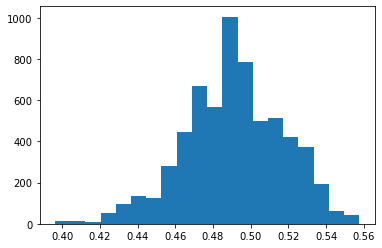

In [56]:
plt.hist(test_df['preds'],bins=20)

(array([ 56., 124., 197., 433., 421., 489., 582., 638., 482., 439., 360.,
        361., 333., 341., 290., 232., 217., 149., 110.,  50.]),
 array([0.04716423, 0.09320068, 0.13923713, 0.18527358, 0.23131003,
        0.27734648, 0.32338293, 0.36941938, 0.41545583, 0.46149228,
        0.50752873, 0.55356519, 0.59960164, 0.64563809, 0.69167454,
        0.73771099, 0.78374744, 0.82978389, 0.87582034, 0.92185679,
        0.96789324]),
 <a list of 20 Patch objects>)

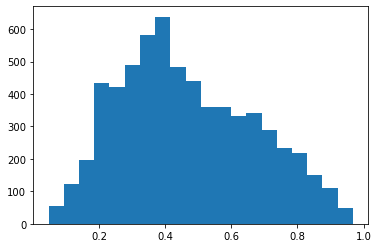

In [62]:
plt.hist(test_df['ratio'],bins=20)


Close enough, lets standardize.


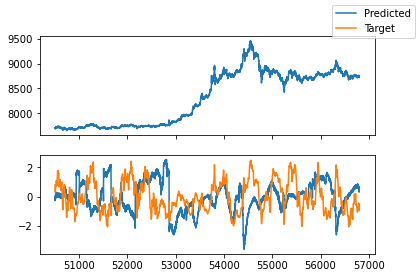

In [59]:
from sklearn import preprocessing

preds_mean =test_df['preds'].mean()
preds_std = test_df['preds'].std()
test_df['preds_scaled'] = (test_df['preds']-preds_mean) / preds_std


ratio_mean =test_df['ratio'].mean()
ratio_std = test_df['ratio'].std()
test_df['ratio_scaled'] = (test_df['ratio']-ratio_mean) / ratio_std

%matplotlib inline
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(test_df['Close'])
ax2.plot(test_df['preds_scaled'], label='Predicted')
ax2.plot(test_df['ratio_scaled'], label='Target')
fig.legend()

Look horrible to me...

So although the Network seemed to learn the results are fairly disappointing.